## Chargement du dataset 

In [1]:
import numpy as np
import os

# Imports nécessaires pour construire un modèle LeNet 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Rescaling

# Pour importer le datasets
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory


# Pour la compilation du modèle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Pour visualiser les performances
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

print(tf.__version__)
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)
tf.keras.backend.clear_session()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


# Chargement du dataset
#dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample"
dir_name = "/mnt/c/Users/karim/rakuten/images/data_clean/images_deep/sample_balanced"
img_size = (224, 224)  # Taille cible
#batch_size = 128
batch_size = 32
class_names = sorted(os.listdir(dir_name))
nb_class = len(class_names)

train_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="training",
    validation_split=0.2,
    seed=42
)

val_ds = image_dataset_from_directory(
    dir_name,
    image_size=img_size,
    batch_size=batch_size,
    subset="validation",
    validation_split=0.2,
    seed=42
)

# 2. Prétraitement pour EfficientNet
preprocess = tf.keras.applications.efficientnet.preprocess_input
train_ds = train_ds.map(lambda x, y: (preprocess(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess(x), y))

# Ajout d'optimisation : mise en cache et préchargement
#train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
#val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

def display_results(model_history, model_name):
    # Récupérer les données d'entraînement et de validation
    train_loss = model_history.history["loss"]
    val_loss = model_history.history["val_loss"]
    train_accuracy =  model_history.history["accuracy"]
    val_accuracy = model_history.history["val_accuracy"]
    
    plt.figure(figsize=(20, 8))
    
    # Tracer la perte
    plt.subplot(121)
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title(model_name + ": Perte d'entraînement et de validation")
    plt.ylabel('Perte ')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    # Tracer l'erreur absolue moyenne (MAE)
    plt.subplot(122)
    plt.plot(train_accuracy)
    plt.plot(val_accuracy)
    plt.title(model_name+': Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Époque')
    plt.legend(['Entraînement', 'Validation'], loc='best')
    
    plt.show()

2025-05-31 10:23:45.984327: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748679826.024428    3250 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748679826.037671    3250 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748679826.092654    3250 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748679826.092675    3250 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748679826.092677    3250 computation_placer.cc:177] computation placer alr

2.19.0
Num GPUs Available:  1
Found 54000 files belonging to 27 classes.
Using 43200 files for training.


I0000 00:00:1748679859.437789    3250 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5222 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 54000 files belonging to 27 classes.
Using 10800 files for validation.


## Structure du modèle

In [2]:
import tensorflow as tf
from keras.saving import register_keras_serializable
     
# 1. Choisir un modèle préentraîné
base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
#base_model.trainable = False  # Geler d'abord le modèle de base

# Dégeler les dernières couches du modèle de base
base_model.trainable = False
for layer in base_model.layers:
    if layer.name.startswith("block7a") or layer.name.startswith("block6a") or layer.name.startswith("top_"):
        layer.trainable = True

# Entrée du modèle
inputs = tf.keras.Input(shape=(224, 224, 3))
    
# Pipeline complet

# Data augmentation
x = tf.keras.layers.RandomFlip("horizontal")(inputs)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomZoom(0.2)(x)
x = tf.keras.layers.RandomContrast(0.2)(x)

 # Modèle de base
x = base_model(x, training=False)

# Couches de classification
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.4)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

outputs = tf.keras.layers.Dense(nb_class, activation='softmax')(x)

# Construction finale
model = tf.keras.Model(inputs, outputs)

#model.summary()

## Entrainement du modèle

Phase 1: Entraînement avec modèle de base gelé
Epoch 1/30


E0000 00:00:1748092577.040065    5751 meta_optimizer.cc:967] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/functional_1/efficientnetb0_1/block2b_drop_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1748092579.712090  162942 cuda_dnn.cc:529] Loaded cuDNN version 90800


1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.1299 - loss: 3.0597   
Epoch 1: val_accuracy improved from -inf to 0.39120, saving model to ../../src/models/EfficientNetB0_model_augmented_best.weights.h5
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 160s 108ms/step - accuracy: 0.1300 - loss: 3.0595 - val_accuracy: 0.3912 - val_loss: 2.0680 - learning_rate: 1.0000e-04
Epoch 2/30
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.3462 - loss: 2.2470  
Epoch 2: val_accuracy improved from 0.39120 to 0.46556, saving model to ../../src/models/EfficientNetB0_model_augmented_best.weights.h5
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 143s 106ms/step - accuracy: 0.3462 - loss: 2.2469 - val_accuracy: 0.4656 - val_loss: 1.8051 - learning_rate: 1.0000e-04
Epoch 3/30
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.4090 - loss: 2.0189   
Epoch 3: val_accuracy improved from 0.46556 to 0.50204, saving model to ../../src/models/EfficientNetB0_model_augmented_best.weights.h5
1350/1350 ━━━━━━━━━━━━━━━━━━━

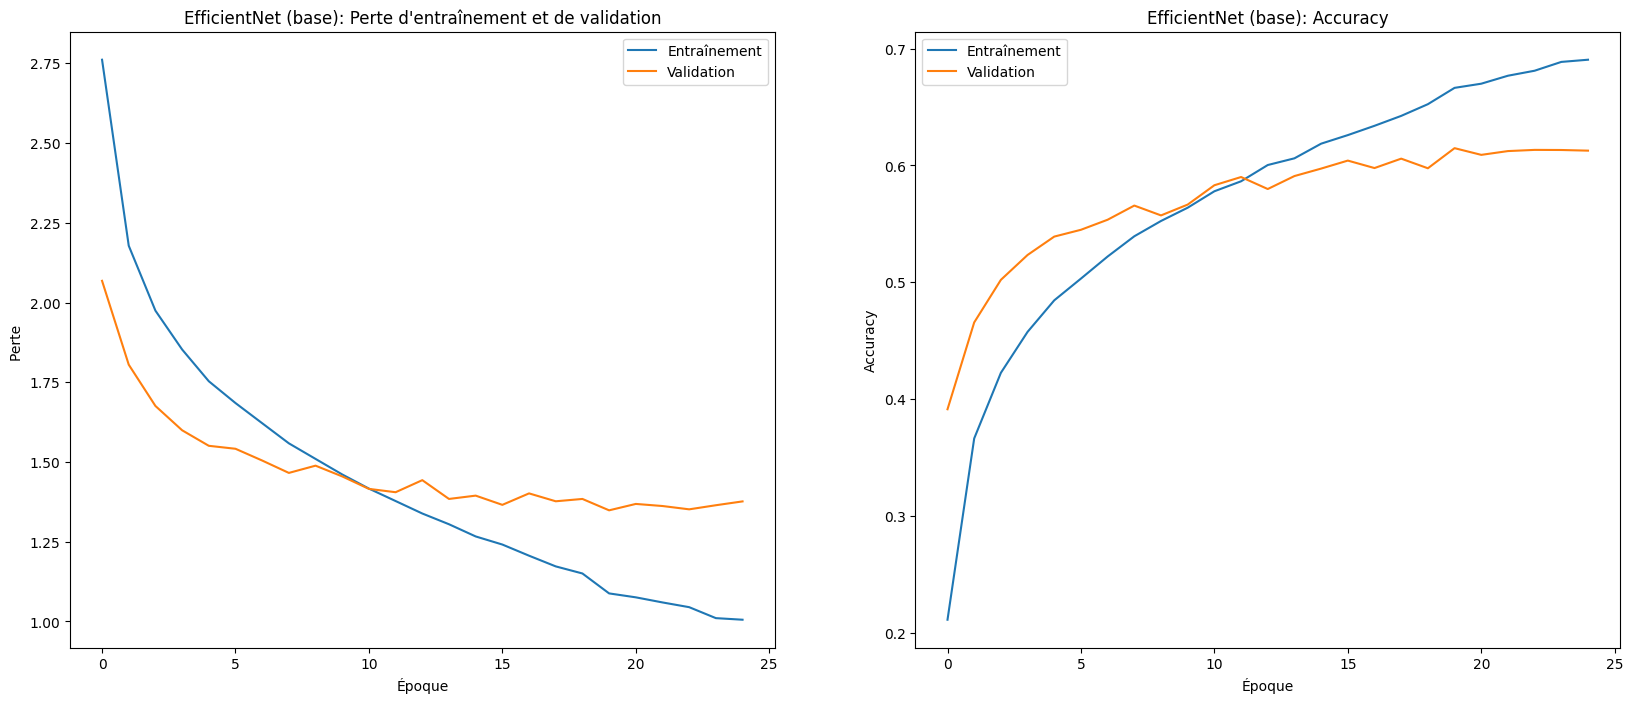

338/338 ━━━━━━━━━━━━━━━━━━━━ 17s 51ms/step - accuracy: 0.6114 - loss: 1.3585
Précision de validation finale: 0.6148


In [3]:
# Définition des callbacks
lr_reducer = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint_weights = tf.keras.callbacks.ModelCheckpoint(
    '../../src/models/EfficientNetB0_model_augmented_best.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_weights_only=True
)

checkpoint_full = tf.keras.callbacks.ModelCheckpoint(
    '../../src/models/EfficientNetB0_model_fine_tuned_best.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1,
    save_weights_only=False
)


# Étape 2: Entraîner avec le modèle de base gelé
print("Phase 1: Entraînement avec modèle de base gelé")

model.compile(
    loss='sparse_categorical_crossentropy',  
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),                 
    metrics=['accuracy'])  

model_history = model.fit(train_ds,           
                           validation_data=val_ds,
                           epochs=30,
                           callbacks=[lr_reducer, early_stopping, checkpoint_weights, checkpoint_full])  


# Étape 3: Fine-tuning - dégeler partiellement le modèle de base
print("Phase 2: Fine-tuning")

# Fonction pour dégeler un bloc spécifique
def unfreeze_block(model, block_prefix):
    print(f"🔓 Déblocage du bloc : {block_prefix}")
    for layer in model.layers:
        if layer.name.startswith(block_prefix):
            layer.trainable = True

# Fonction pour recompiler et entraîner
def compile_and_fit(model, learning_rate, epochs=2):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Plus petit LR en fine-tuning
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    # Entraîner avec fine-tuning
    return model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping, lr_reducer, checkpoint]
    )

# 4. Fine-tuning progressif
#unfreeze_block(model, "top_")
#unfreeze_block(model, "block7a")
#unfreeze_block(model, "block6a")
#history_phase2 = compile_and_fit(model, learning_rate = 1e-5)
#unfreeze_block(model, "block6a")
#history_phase3 = compile_and_fit(model, learning_rate = 1e-5)

# Sauvegarde du modèle final
model.save('../../src/models/EfficientNetB0_model_fine_tuned_final.keras')

# Analyse de l'entainement
print("Analyse entraintement")
display_results(model_history, "EfficientNet (base)")

# Analyse de l'entainement
#print("Analyse entraintement EfficientNet (fine tunning)")
#display_results(history_phase2, "EfficientNet (fine tunning)")

# Analyse de l'entainement
#print("Analyse entraintement EfficientNet (fine tunning)")
#display_results(history_phase3, "EfficientNet (fine tunning)")

# Évaluation finale
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Précision de validation finale: {val_accuracy:.4f}")



## Analyse de la performance par classe

In [2]:
# Chargement du model
model_loaded =  tf.keras.models.load_model('../../models/EfficientNetB0/EfficientNetB0_model_finetuned_best.keras')

# Check
#model_loaded.summary()

/home/karim/SEP24_CDS_Rakuten/env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 24 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 5,907,595 (22.54 MB)

 Trainable params: 1,493,707 (5.70 MB)

 Non-trainable params: 2,920,179 (11.14 MB)

 Optimizer params: 1,493,709 (5.70 MB)

In [4]:
### ANALYSE DE LA PERFORMANCE ###

from sklearn.metrics import classification_report

# 1. Générer des prédictions sur l'ensemble de validation
# Prévoir les classes pour tous les échantillons de validation
predictions = []
labels = []

# Récupérer toutes les étiquettes et prédictions
for images, true_labels in val_ds:
    pred = model_loaded.predict(images)
    pred_classes = np.argmax(pred, axis=1)
    
    predictions.extend(pred_classes)
    labels.extend(true_labels.numpy())

# Convertir en arrays numpy
predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names))

# 2. Créer et afficher la matrice de confusion
"""
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.show()
"""

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

2025-05-31 10:30:43.405160: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


"\ncm = confusion_matrix(labels, predictions)\nplt.figure(figsize=(10, 8))\nsns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)\nplt.xlabel('Prédiction')\nplt.ylabel('Réalité')\nplt.title('Matrice de confusion')\nplt.show()\n"